In [ ]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
 
import warnings
warnings.filterwarnings('ignore')

# File Tools for local
import pandas as pd
import sys

# Random seed for reproducibility
import random

import torch
from botorch.utils.transforms import unnormalize, normalize

from ipywidgets import interact, FloatSlider

#LHS sampling
#from pyDOE import lhs

#from BOClass import Models, Plotting, PoolObjectives
from boclass_3Dprint import Models, Plotting, PoolObjectives

dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
columns = ['n',	'theta','r','t','toughness']
all_data = pd.read_csv('parameterspace.csv')[columns]


# Group by the specified columns and calculate stats
grouped = all_data.groupby(['n', 'theta', 'r', 't']).agg(
    toughness_mean=('toughness', 'mean'),
    toughness_variance=('toughness', 'var'),
    count=('toughness', 'count')
).reset_index()

# Keep only groups where count > 1 (i.e., duplicates)
train_data = grouped[grouped['count'] > 1]

# print(train_data.head())

x_inputs = train_data[["n", "theta", "r", "t"]]
y_outputs = train_data["toughness_mean"]
yvar_outputs = train_data["toughness_variance"]
# Set the device and dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
# Convert to torch tensors
x_all = torch.tensor(x_inputs.to_numpy(), dtype=torch.float32)
y_all = torch.tensor(y_outputs.values.reshape(-1, 1), dtype=torch.float32)

# Show top 10 highest toughness values and their corresponding inputs
topk = 10
topk_indices = y_all.flatten().argsort(descending=True)[:topk]
for idx in topk_indices:
    print(f"Toughness: {y_all[idx].item():.4f}, Inputs: {x_all[idx].tolist()}")


Toughness: 46.7114, Inputs: [12.0, 150.0, 1.899999976158142, 1.399999976158142]
Toughness: 44.9449, Inputs: [12.0, 75.0, 2.4000000953674316, 1.0499999523162842]
Toughness: 44.4266, Inputs: [12.0, 25.0, 2.4000000953674316, 0.699999988079071]
Toughness: 43.3273, Inputs: [12.0, 75.0, 2.4000000953674316, 0.699999988079071]
Toughness: 41.5731, Inputs: [12.0, 200.0, 1.5, 1.399999976158142]
Toughness: 41.1616, Inputs: [12.0, 125.0, 2.0, 1.399999976158142]
Toughness: 40.0132, Inputs: [12.0, 175.0, 1.600000023841858, 1.399999976158142]
Toughness: 39.7673, Inputs: [10.0, 200.0, 1.7000000476837158, 1.399999976158142]
Toughness: 39.2423, Inputs: [12.0, 100.0, 2.5, 0.699999988079071]
Toughness: 39.0914, Inputs: [12.0, 25.0, 2.200000047683716, 0.699999988079071]


In [3]:
random_seed = 1
iterations = 10

batch_size = 6
# Iteration 0: Set up gp with initial data
original_bounds = torch.tensor([[x_all[:, 0].min(), x_all[:, 0].max()],
                      [x_all[:, 1].min(), x_all[:, 1].max()],
                      [x_all[:, 2].min(), x_all[:, 2].max()],
                      [x_all[:, 3].min(), x_all[:, 3].max()]], dtype=torch.float32).T


x_inputs = train_data[['n','theta','r','t'] ]
y_outputs = train_data["toughness_mean"]
yvar_outputs = train_data["toughness_variance"]
# Set the device and dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
# Convert to torch tensors
x_all = torch.tensor(x_inputs.to_numpy(), dtype=torch.float32)
nx_all = normalize(x_all,original_bounds)
y_all = torch.tensor(y_outputs.values.reshape(-1, 1), dtype=torch.float32)
yvar_all = torch.tensor(yvar_outputs.values.reshape(-1, 1), dtype=torch.float32)

random.seed(0)
random_indices = random.sample(range(x_all.shape[0]), batch_size)
x_train = x_all[random_indices]
nx_train = normalize(x_train, bounds=original_bounds) # normalized data for training

y_train = y_all[random_indices]
y_train_var = yvar_all[random_indices]


# Convert x_train to numpy for comparison
x_train_np = x_train.cpu().numpy()
# Find all rows in x_inputs that are not in x_train
mask = ~x_inputs.apply(lambda row: ((x_train_np == row.values).all(axis=1)).any(), axis=1)
x_input_new = x_inputs[mask]
y_output_new = y_outputs[mask]
yvar_output_new = yvar_outputs[mask]
query = PoolObjectives(x_input_new, y_output_new ,yvar_output_new, columns=['n', 'theta', 'r', 't'])
# Step 1: Initialize your model
gp_model = Models(x_train=nx_train, y_train=y_train, y_train_var=y_train_var, bounds=original_bounds, batch_size=batch_size, objective=query)

# Step 2: Initialize Plotting class
# variable_combinations = [('time', 'sulf', 'anly'), ('time', 'anly', 'sulf'), ('sulf', 'anly', 'time')]
# plotting = Plotting(gp_model, variable_combinations=variable_combinations)

# combination = variable_combinations[0]
# minmax = [y_train.min(), y_train.max()]
# plotting.sliced_plotting('ModelA',combination, minmax)



In [4]:
def BO_loop_ModelA(gp_model,train_nx, train_y,train_yvar, x_all, y_all, yvar_all,iterations=5):
    query = PoolObjectives(x_all, y_all, yvar_all, columns=['n', 'theta', 'r', 't'])
    for i in range(iterations):
        # Step 3: Get the next candidates
        new_candidates = gp_model.ModelA_candidates(feature='theta').drop(columns=['cluster'])
        
        #print(new_candidates.shape)
        # Remove new_candidates from x_all
        x_actual, y_actual, yvar_actual, used_id = query.find_nearest(new_candidates)
        print(used_id)

        nx_train = normalize(x_actual, bounds=original_bounds)
        #print(x_train.shape, y_train.shape, yvar_train.shape)
        # Combine the new data with the existing data
        train_nx = torch.cat((train_nx, nx_train), dim=0)
        train_y = torch.cat((train_y, y_actual), dim=0)
        train_yvar = torch.cat((train_yvar, yvar_actual), dim=0)
        #print(train_nx.shape, train_y.shape, train_yvar.shape)
        # Step 1: Instantiate and train model
        gp_model = Models(x_train=train_nx, y_train=train_y, y_train_var=train_yvar, bounds=original_bounds, batch_size=batch_size, objective=query, random_id = random_seed)

    return gp_model, train_nx, train_y, train_yvar


[85, 82, 88, 547, 79, 546]
[543, 540, 148, 544, 498, 396]
[531, 4, 248, 465, 236, 528]
[61, 440, 472, 504, 513, 434]
[582, 145, 263, 532, 375, 401]
[230, 233, 337, 77, 70, 132]
[515, 13, 514, 419, 362, 354]
[511, 364, 363, 153, 510, 567]
[433, 508, 64, 583, 402, 258]
[175, 481, 169, 597, 507, 471]


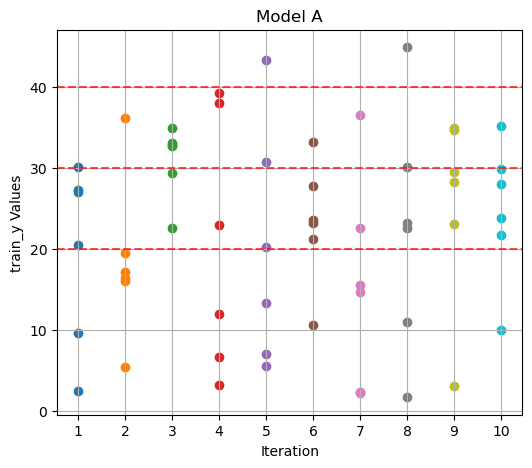

Iteration 1: tensor([ 10.0000, 125.0000,   2.2000,   1.0500])
Iteration 2: tensor([ 12.0000, 125.0000,   2.4000,   0.7000])
Iteration 3: tensor([12.0000, 50.0000,  2.5000,  0.7000])
Iteration 4: tensor([ 12.0000, 100.0000,   2.5000,   0.7000])
Iteration 5: tensor([12.0000, 75.0000,  2.4000,  0.7000])
Iteration 6: tensor([ 12.0000, 200.0000,   1.5000,   0.7000])
Iteration 7: tensor([  8.0000, 100.0000,   2.5000,   1.4000])
Iteration 8: tensor([12.0000, 75.0000,  2.4000,  1.0500])
Iteration 9: tensor([12.0000, 75.0000,  2.2000,  1.0500])
Iteration 10: tensor([ 12.0000, 200.0000,   1.5000,   1.0500])


In [5]:
thresholds = [20, 30, 40]

gp_modeA, train_nA, train_yA, train_yvaA = BO_loop_ModelA(gp_model, nx_train, y_train, y_train_var, x_input_new, y_output_new ,yvar_output_new, iterations = iterations)

train_xA = unnormalize(train_nA, original_bounds)
# Step 2: Initialize Plotting class
variable_combinations = [('time', 'sulf', 'anly'), ('n', 'r', 't')]
plotting = Plotting(gp_modeA, variable_combinations=variable_combinations)

combination = variable_combinations[1]

minmax = [y_train.min(), y_train.max()]
# plotting.sliced_plotting('ModelA',combination, minmax)

# Split train_y intoA iterations, each containingA points

points_per_iteration = batch_size
split_data = [train_yA[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]
split_datax = [train_xA[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]

# Plot the points vertically
plt.figure(figsize=(6, 5))
for i, data in enumerate(split_data):
    plt.scatter([i + 1] * len(data), data.numpy(), label=f'Iteration {i + 1}')

plt.xlabel('Iteration')
plt.ylabel('train_y Values')
plt.title('Model A')
plt.xticks(range(1, iterations + 1))

for thresh in thresholds:
    plt.axhline(y=thresh, color='red', linestyle='--', alpha=0.7)
# plt.legend()
plt.grid(True)
plt.show()
argmax_indices = [data.argmax().item() for data in split_data]
for i, idx in enumerate(argmax_indices):
    print(f"Iteration {i + 1}: {split_datax[i][idx]}")

In [6]:
def BO_loop_ModelB(gp_model,train_nx, train_y,train_yvar, x_all, y_all, yvar_all,iterations=5):
    query = PoolObjectives(x_all, y_all, yvar_all, columns=['n', 'theta', 'r', 't'])
    for i in range(iterations):
        # Step 3: Get the next candidates
        new_candidates = gp_model.ModelB_candidates(feature='theta')#.drop(columns=['cluster'])
        
        #print(new_candidates.shape)
        # Remove new_candidates from x_all
        x_actual, y_actual, yvar_actual, used_id = query.find_nearest(new_candidates)

        nx_train = normalize(x_actual, bounds=original_bounds)
        #print(x_train.shape, y_train.shape, yvar_train.shape)
        # Combine the new data with the existing data
        train_nx = torch.cat((train_nx, nx_train), dim=0)
        train_y = torch.cat((train_y, y_actual), dim=0)
        train_yvar = torch.cat((train_yvar, yvar_actual), dim=0)
        #print(train_nx.shape, train_y.shape, train_yvar.shape)
        # Step 1: Instantiate and train model
        gp_model = Models(x_train=train_nx, y_train=train_y, y_train_var=train_yvar, bounds=original_bounds, batch_size=batch_size, objective=query, random_id = random_seed)

    return gp_model, train_nx, train_y, train_yvar


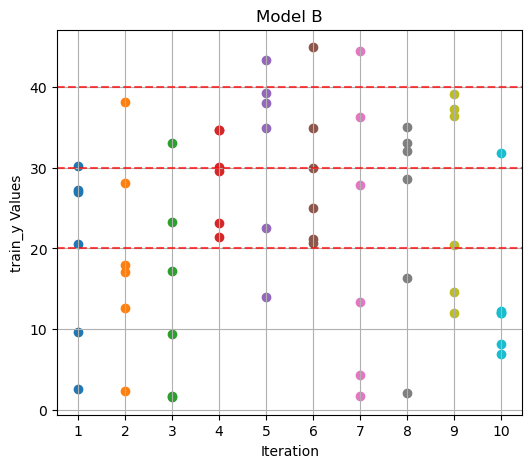

Iteration 1: tensor([ 10.0000, 125.0000,   2.2000,   1.0500])
Iteration 2: tensor([ 12.0000, 100.0000,   2.3000,   1.0500])
Iteration 3: tensor([ 12.0000, 125.0000,   2.2000,   0.7000])
Iteration 4: tensor([10.0000, 75.0000,  2.4000,  1.0500])
Iteration 5: tensor([12.0000, 75.0000,  2.4000,  0.7000])
Iteration 6: tensor([12.0000, 75.0000,  2.4000,  1.0500])
Iteration 7: tensor([12.0000, 25.0000,  2.4000,  0.7000])
Iteration 8: tensor([ 12.0000, 175.0000,   2.4000,   0.7000])
Iteration 9: tensor([12.0000, 25.0000,  2.2000,  0.7000])
Iteration 10: tensor([ 12.0000, 175.0000,   2.2000,   0.7000])


In [7]:
# Reset Pool
x_inputs = train_data[['n', 'theta', 'r', 't']]
y_outputs = train_data["toughness_mean"]
yvar_outputs = train_data["toughness_variance"]

gp_modelB, train_nxB, train_yB, train_yvarB = BO_loop_ModelB(gp_model, nx_train, y_train, y_train_var, x_input_new, y_output_new ,yvar_output_new, iterations = iterations)

train_xB = unnormalize(train_nxB, original_bounds)
# Step 2: Initialize Plotting class
variable_combinations = [('n', 't', 'r'), ('theta', 'r', 't'), ('n', 't', 'theta')]
plotting = Plotting(gp_modelB, variable_combinations=variable_combinations)

combination = variable_combinations[0]

minmax = [y_train.min(), y_train.max()]
# plotting.sliced_plotting('ModelB',combination, minmax)


points_per_iteration = batch_size
split_data = [train_yB[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]
split_datax = [train_xB[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]

# Plot the points vertically
plt.figure(figsize=(6, 5))
for i, data in enumerate(split_data):
    plt.scatter([i + 1] * len(data), data.numpy(), label=f'Iteration {i + 1}')

plt.xlabel('Iteration')
plt.ylabel('train_y Values')
plt.title('Model B')
plt.xticks(range(1, iterations + 1))
for thresh in thresholds:
    plt.axhline(y=thresh, color='red', linestyle='--', alpha=0.7)
# plt.legend()
plt.grid(True)
plt.show()
argmax_indices = [data.argmax().item() for data in split_data]
for i, idx in enumerate(argmax_indices):
    print(f"Iteration {i + 1}: {split_datax[i][idx]}")

In [8]:
def BO_loop_ModelC(gp_model,train_nx, train_y,train_yvar, x_all, y_all, yvar_all,iterations=5):
    query = PoolObjectives(x_all, y_all, yvar_all, columns=['n', 'theta', 'r', 't'])
    for i in range(iterations):
        # Step 3: Get the next candidates
        new_candidates = gp_model.ModelC_candidates(feature='theta')#.drop(columns=['cluster'])
        
        #print(new_candidates.shape)
        # Remove new_candidates from x_all
        x_actual, y_actual, yvar_actual, used_id = query.find_nearest(new_candidates)

        nx_train = normalize(x_actual, bounds=original_bounds)
        #print(x_train.shape, y_train.shape, yvar_train.shape)
        # Combine the new data with the existing data
        train_nx = torch.cat((train_nx, nx_train), dim=0)
        train_y = torch.cat((train_y, y_actual), dim=0)
        train_yvar = torch.cat((train_yvar, yvar_actual), dim=0)
        #print(train_nx.shape, train_y.shape, train_yvar.shape)
        # Step 1: Instantiate and train model
        gp_model = Models(x_train=train_nx, y_train=train_y, y_train_var=train_yvar, bounds=original_bounds, batch_size=batch_size, objective=query, random_id = random_seed)

    return gp_model, train_nx, train_y, train_yvar


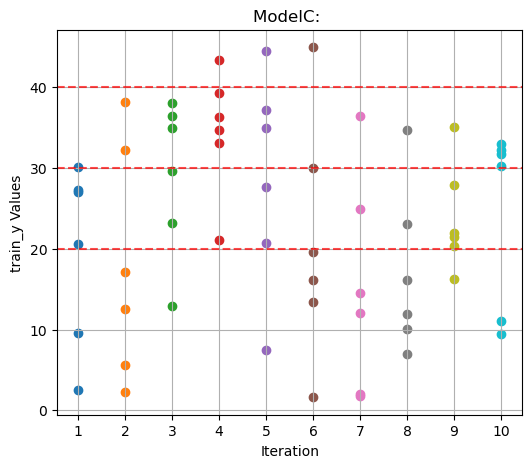

Iteration 1: tensor([ 10.0000, 125.0000,   2.2000,   1.0500])
Iteration 2: tensor([ 12.0000, 100.0000,   2.3000,   1.0500])
Iteration 3: tensor([ 12.0000, 100.0000,   2.3000,   0.7000])
Iteration 4: tensor([12.0000, 75.0000,  2.4000,  0.7000])
Iteration 5: tensor([12.0000, 25.0000,  2.4000,  0.7000])
Iteration 6: tensor([12.0000, 75.0000,  2.4000,  1.0500])
Iteration 7: tensor([ 12.0000, 200.0000,   2.3000,   0.7000])
Iteration 8: tensor([10.0000, 75.0000,  2.4000,  1.0500])
Iteration 9: tensor([ 12.0000, 175.0000,   2.4000,   0.7000])
Iteration 10: tensor([ 12.0000, 150.0000,   2.5000,   0.7000])


In [9]:
# Reset 
x_inputs = train_data[['n', 'theta', 'r', 't']]
y_outputs = train_data["toughness_mean"]
yvar_outputs = train_data["toughness_variance"]

gp_modelC, train_nxC, train_yC, train_yvarC = BO_loop_ModelC(gp_model, nx_train, y_train, y_train_var, x_input_new, y_output_new ,yvar_output_new, iterations = iterations)

train_xC = unnormalize(train_nxC, original_bounds)
# Step 2: Initialize Plotting class
variable_combinations = [('time', 'sulf', 'anly'), ('theta', 'r', 't'), ('n', 't', 'theta')]
plotting = Plotting(gp_modelC, variable_combinations=variable_combinations)

combination = variable_combinations[0]

minmax = [y_train.min(), y_train.max()]
# plotting.sliced_plotting('ModelC',combination, minmax)


points_per_iteration = batch_size
split_data = [train_yC[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]
split_datax = [train_xC[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]

# Plot the points vertically
plt.figure(figsize=(6, 5))
for i, data in enumerate(split_data):
    plt.scatter([i + 1] * len(data), data.numpy(), label=f'Iteration {i + 1}')

plt.xlabel('Iteration')
plt.ylabel('train_y Values')
plt.title('ModelC: ')
plt.xticks(range(1, iterations + 1))
for thresh in thresholds:
    plt.axhline(y=thresh, color='red', linestyle='--', alpha=0.7)
# plt.legend()
plt.grid(True)
plt.show()

argmax_indices = [data.argmax().item() for data in split_data]
for i, idx in enumerate(argmax_indices):
    print(f"Iteration {i + 1}: {split_datax[i][idx]}")



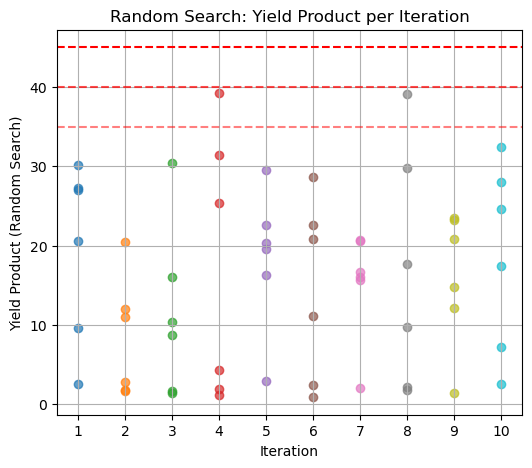

In [10]:
# Perform a random search on set_dataA for 5 random samples

iteration = np.arange(1, iterations+1)

num_samples = batch_size * (iterations-1)
random_samples = train_data.sample(n=num_samples, random_state=random_seed)
# Combine y_train (tensor) and the remaining random samples (list of Series)
y_train_df = pd.DataFrame(y_train.numpy(), columns=['toughness_mean'])
random_sampling = [y_train_df] + [random_samples.iloc[i*batch_size:(i+1)*batch_size]['toughness_mean'] for i in range(iterations-1)]


plt.figure(figsize=(6, 5))
for i, samples in enumerate(random_sampling):
    plt.scatter([iteration[i]] * len(samples), samples.values, alpha=0.7)
plt.xlabel('Iteration')
plt.axhline(y=45, color='red', linestyle='--', label='y=40')
plt.axhline(y=40, color='red', linestyle='--', label='y=40', alpha=0.7)
plt.axhline(y=35, color='red', linestyle='--', label='y=40', alpha=0.5)
plt.ylabel('Yield Product (Random Search)')
plt.title('Random Search: Yield Product per Iteration')
plt.grid(True)
plt.xticks(range(1, iterations + 1))
plt.show()


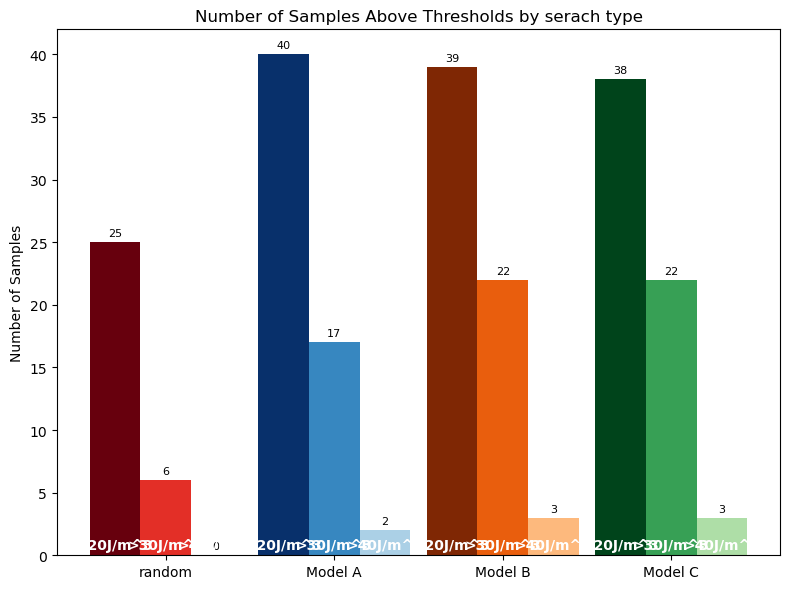

In [11]:
# Check Data
thresholds = [20, 30, 40]

flattened_random_sampling = pd.concat(random_sampling).values.flatten().reshape(-1, 1)

idsA = [(train_yA > thresh).sum().item() for thresh in thresholds]
idsB = [(train_yB > thresh).sum().item() for thresh in thresholds]
idsC = [(train_yC > thresh).sum().item() for thresh in thresholds]
ids_random = [(flattened_random_sampling > thresh).sum().item() for thresh in thresholds]


model_counts =[ids_random,idsA,idsB,idsC] 
model_names = ['random','ModelA', 'ModelB', 'ModelC']  # Used for cm.*
num_bars_per_model = len(thresholds)

# Bar settings
bar_width = 0.3
x = np.arange(len(model_names))

# Colormap mapping
cmap_dict = {'random':cm.Reds, 'ModelA': cm.Blues, 'ModelB': cm.Oranges, 'ModelC': cm.Greens}

# Create plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each model group
for i, (model, counts) in enumerate(zip(model_names, model_counts)):
    cmap = cmap_dict[model]
    # Light to dark (0 = light, 1 = dark); reversed here for higher threshold to be lighter
    gradient_colors = [cmap(1 - j / num_bars_per_model) for j in range(num_bars_per_model)]
    
    for j, count in enumerate(counts):
        # j = threshold index (0: 0.5, 1: 0.7, 2: 0.9)
        xpos = x[i] + j * bar_width - bar_width  # Center group around x[i]
        rect = ax.bar(xpos, count, width=bar_width, color=gradient_colors[j],
                      label=f'{model} - {thresholds[j]:.1f}' if i == 0 else None)  # Only label once per threshold
        ax.bar_label(rect, padding=3, fontsize=8)

# Ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(['random','Model A', 'Model B', 'Model C'])
ax.set_ylabel('Number of Samples')
ax.set_title('Number of Samples Above Thresholds by serach type')

# Add annotations for thresholds
for i, model in enumerate(model_names):
    for j, count in enumerate(model_counts[i]):
        xpos = x[i] + j * bar_width - bar_width  # Center group around x[i]
        ax.text(xpos, 0.3, f'>{thresholds[j]:.0f}J/m^3', ha='center', va='bottom', fontsize=10, fontweight = 'bold',color='white')

plt.tight_layout()
plt.show()

